# Deep Learning Fundamentals Lab 6 -- Regularization

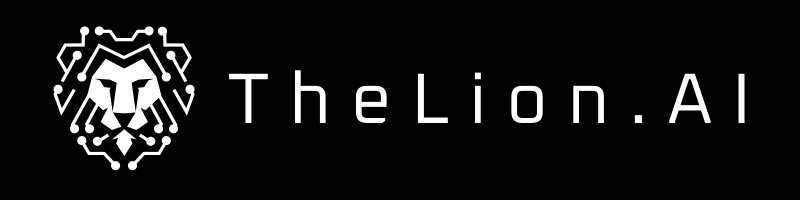

Welcome to the second installment of our Deep Learning Fundamentals laboratory series, presented by [TheLion.AI](https://www.thelion.ai/) — an interdisciplinary research group specializing in AI-based healthcare solutions. This comprehensive program is designed to equip you with practical skills in implementing deep learning models across various domains, with a special emphasis on natural language processing and computer vision. We like to make our software and teaching materials as accessible as possible. If you like what we do, consider supporting us at [https://buymeacoffee.com/thelionai](https://buymeacoffee.com/thelionai).

The course follows a progressive learning path, starting with foundational concepts and gradually building up to advanced techniques. Each lab session includes a brief overview of key concepts and hands-on coding exercises.

**New notebooks will be added weekly!**

### Syllabus
1. [Introduction to sci-kit learn](https://www.kaggle.com/code/basia25/introduction-to-scikit-learn/)
2. [Introduction to linear algebra in PyTorch](https://www.kaggle.com/code/basia25/introduction-to-linear-algebra-in-pytorch/)
3. [Neural network from scratch](https://www.kaggle.com/code/basia25/neural-network-from-scratch/)
4. [Neural network in pure PyTorch](https://www.kaggle.com/code/basia25/neural-network-in-pure-pytorch/)
5. [Neural network in PyTorch Lightning](https://www.kaggle.com/code/basia25/intro-to-pytorch-lightning)
6. [Regularization methods](https://www.kaggle.com/code/basia25/introduction-to-regularization/)
7. Convolutional neural networks
8. State-of-the-art CNNs
9. Image segmentation
10. NLP fundamentals
11. HuggingFace
12. Sentence transformers
13. Explainable AI
14. Image transformer and AI in Healthcare
15. Running experiments in ClearML
16. Creating smart configuration files with Hydra

# Introduction

In this exercise, we'll explore regularization techniques to prevent overfitting in neural networks. We'll work with the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. Our goal is to implement and compare three regularization methods: Dropout, Batch Normalization, and L2 Regularization.

### Key Concepts
**Overfitting**

Overfitting occurs when a model learns the training data too well, including noise and outliers, resulting in poor generalization to new, unseen data. This is evident when training loss continues to decrease while validation loss starts to increase.

**Regularization**

Regularization techniques help prevent overfitting by adding constraints to the model during training:
- **Dropout**: Randomly deactivates a fraction of neurons during training, forcing the network to learn redundant representations
- **Batch Normalization**: Normalizes the outputs of a layer, reducing internal covariate shift and acting as a regularizer
- **L2 Regularization**: Adds a penalty term to the loss function based on the magnitude of the model's weights

In [ ]:
!pip install pytorch-lightning

In [ ]:
from torchvision import datasets, transforms
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Subset
import torch

In [ ]:
class CIFARDatamodule(pl.LightningDataModule):
  def __init__(self, batch_size = 32):
    super().__init__()
    self.batch_size = batch_size
  def setup(self, stage = None):
    transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0), (1))
                                ])

    self.train_dataset = Subset(datasets.CIFAR10(root='data/', train=True, download=True, transform=transform),torch.arange(100))
    self.test_dataset = Subset(datasets.CIFAR10(root='data/', train=False, download=True, transform=transform),torch.arange(100, 150))


  def train_dataloader(self):
    return  DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)
  def val_dataloader(self):
    return  DataLoader(self.test_dataset, batch_size = self.batch_size, shuffle = False)

In [ ]:
data_module = CIFARDatamodule()

In [ ]:
data_module.setup()

In [ ]:
len(data_module.train_dataloader())

## Model

In [ ]:
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch import flatten
import torchmetrics

In [ ]:
class CIFARModel(pl.LightningModule):
  def __init__(self, input_size, num_classes):
    super().__init__()

    self.input_size = input_size

    self.loss_function = nn.CrossEntropyLoss()

    self.fc1 = nn.Linear(input_size, 5000)
    self.fc2 = nn.Linear(5000, 5000)
    self.fc3 = nn.Linear(5000, num_classes)

    self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
    self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)

    self.train_macro_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')
    self.val_macro_f1 = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')

  def forward(self, x):
    x = x.view(x.shape[0], self.input_size)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

  def configure_optimizers(self):
    optimizer =  optim.SGD(self.parameters(), lr = 0.01)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    inputs, labels = train_batch


    outputs = self.forward(inputs.float())
    loss = self.loss_function(outputs, labels)

    self.log('train_loss', loss, on_step= True, on_epoch = True)

    outputs = F.softmax(outputs, dim =1)

    self.train_acc(outputs, labels)
    self.log('train_acc', self.train_acc, on_epoch=True, on_step= False)

    self.train_macro_f1(outputs, labels)
    self.log('train_macro_f1', self.train_macro_f1, on_epoch=True, on_step= False)


    return loss

  def validation_step(self, val_batch, batch_idx):
    inputs, labels = val_batch


    outputs = self.forward(inputs.float())
    loss = self.loss_function(outputs, labels)

    self.log('val_loss', loss,  on_step= True, on_epoch = True)


    outputs = F.softmax(outputs, dim =1)

    self.val_acc(outputs, labels)
    self.log('val_acc', self.val_acc, on_epoch=True, on_step= False)

    self.val_macro_f1(outputs, labels)
    self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, on_step= False)

    return loss

In [ ]:
baseline_model = CIFARModel(32*32*3,10)

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger
%load_ext tensorboard
%tensorboard --logdir lightning_logs

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="baseline model", )

In [ ]:
trainer = pl.Trainer(logger = logger, max_epochs = 100, log_every_n_steps =1)

In [ ]:
trainer.fit(baseline_model, data_module, )

# Overfitting
We can observe in the plots that from a certain point `val_loss` begins to increase, despite the fact that `train_loss` continues to decrease. This phenomenon is called overfitting and means that the model overfits the training data and loses its ability to generalize. In the following examples, you will implement 3 methods that we use to reduce overfitting. These methods are called regularization and are related to simplifying the complexity of the model.

### 1. Dropout
This technique ignores some outputs of a layer during the training by replacing them with zeros.

In [ ]:
dropout = nn.Dropout(0.5)

In [ ]:
input = torch.randn(2, 16)
input

In [ ]:
output = dropout(input)
output

## 2. Batch normalization
Polega na dodaniu dodatkowej warstwy modelu, która centruje wejścia i je przeskalowuje.

In [ ]:
input = torch.randn(2, 16)
input

In [ ]:
print(f"Mean: {input.mean()}")
print(f"Std dev: {input.std()}")

In [ ]:
batch_norm = nn.BatchNorm1d(16) # batch norm

In [ ]:
normalized = batch_norm(input)
normalized

In [ ]:
print(f"Mean: {normalized.mean()}")
print(f"Std dev: {normalized.std()}")

## 3. L2 regularization
L2 regularization involves adding an additional component to the error function. This component is the sum of the squares of all the weights of the model. L2 regularization makes weights close to zero have a negligible effect on the model, while large weights gain more importance. In this way, we simplify the complexity of the model.

Regularization $L_2 = ||w||^2_2 = w_1^2+w_2^2+\dots+w_n^2$

# Exercises

## 1. Dropout
Implement the dropout in the lines marked with the comment “TODO”.

## 2. Batch Normalization
Add normalization in lines marked with TODO comments.

## 3. L2 regularization
Add L2 regularization to the model

In [ ]:
class CIFARDropoutModel(pl.LightningModule):
  def __init__(self, input_size, num_classes):
    super().__init__()

    self.loss_function = nn.CrossEntropyLoss()
    self.input_size = input_size

    self.fc1 = nn.Linear(input_size, 5000)
    # TODO: batch norm
    self.fc2 = nn.Linear(5000, 5000)
    # TODO: batch norm
    self.fc3 = nn.Linear(5000, num_classes)
    # initialize dropout

    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()

    self.train_macro_f1 = torchmetrics.F1Score(num_classes=num_classes, average='macro')
    self.val_macro_f1 = torchmetrics.F1Score(num_classes=num_classes, average='macro')

  def forward(self, x):
    x = x.view(x.shape[0], self.input_size)
    x = self.fc1(x)
    # TODO: batch norm
    # TODO: add dropout after each hidden layer
    x = F.relu(x)
    x = self.fc2(x)
    # TODO: batch norm
    # calculate dropout after each hidden layer
    x = F.relu(x)
    x = self.fc3(x)
    return x

  def configure_optimizers(self):
    # TODO: L2 regularization is implemented in pytorch as a weight decay parameter in the optimizer
    optimizer =  optim.SGD(self.parameters(), lr = 0.01)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    inputs, labels = train_batch


    outputs = self.forward(inputs.float())
    loss = self.loss_function(outputs, labels)

    self.log('train_loss', loss, on_step= True, on_epoch = True)

    outputs = F.softmax(outputs, dim =1)

    self.train_acc(outputs, labels)
    self.log('train_acc', self.train_acc, on_epoch=True, on_step= True)

    self.train_macro_f1(outputs, labels)
    self.log('train_macro_f1', self.train_macro_f1, on_epoch=True, on_step= False)


    return loss

  def validation_step(self, val_batch, batch_idx):
    inputs, labels = val_batch


    outputs = self.forward(inputs.float())
    loss = self.loss_function(outputs, labels)

    self.log('val_loss', loss,  on_step= True, on_epoch = True)

    outputs = F.softmax(outputs, dim =1)

    self.val_acc(outputs, labels)
    self.log('val_acc', self.val_acc, on_epoch=True, on_step= False)

    self.val_macro_f1(outputs, labels)
    self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, on_step= False)

    return loss

In [ ]:
dropout_model = CIFARDropoutModel(32*32*3,10)

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="dropout model")

In [ ]:
trainer = pl.Trainer(logger = logger, max_epochs = 100, log_every_n_steps =1)

In [ ]:
trainer.fit(dropout_model, data_module)